
# MNIST Softmax Classifier — Forward/Backward Pass (Step‑by‑Step) + Animations

You’ll build and **understand** a single‑layer neural network (softmax classifier / multinomial logistic regression) for MNIST **from scratch** in NumPy.  
We’ll cover:
1. Data prep (flattening 28×28 → 784).
2. Forward pass: \( \mathbf{Z} = \mathbf{X}\mathbf{W} + \mathbf{b} \), \( \hat{\mathbf{Y}} = \mathrm{softmax}(\mathbf{Z}) \).
3. Loss: average cross‑entropy.
4. Backprop: gradients for \( \mathbf{W}, \mathbf{b} \) via the compact **softmax + CE** identity.
5. Training loop with gradient descent.
6. **Matplotlib animations** for loss and for a single example’s probability vector during training.

> **Network layout**: `Input 784 → Linear (784×10) → Softmax → 10 classes`. No hidden layers.


In [18]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

np.random.seed(42)


```markdown
## Model Architecture — Softmax Classifier

The architecture above shows a single-layer neural network that performs multinomial logistic regression (softmax classification).

Dimensions:
- Input: 784 (flattened MNIST images)  
- Weights: 784×10 matrix 
- Bias: 1×10 vector
- Output: 10 classes (digits 0-9)
```

![Classifier Architecture](./images/forward_propagation.png)


![Classifier Architecture](./images/classification_network.png)


![Softmax Classifier Architecture](./images/softmax_schematic_1.png)

![Softmax](./images/soft_max.png)


## 1. Math — Forward pass and Loss

Let $X\in\mathbb{R}^{m\times 784}$ be a batch of $m$ flattened images, $W\in\mathbb{R}^{784\times 10}$, $b\in\mathbb{R}^{1\times 10}$.
The **logits** (pre‑softmax scores) are
$$
\mathbf{Z} = \mathbf{X}\mathbf{W} + \mathbf{b} \quad\in\mathbb{R}^{m\times 10}.
$$
Softmax (row‑wise) yields class probabilities:
$$
\hat{\mathbf{Y}}_{i,c} = \frac{e^{Z_{i,c} - \max_j Z_{i,j}}}{\sum_{k=1}^{10} e^{Z_{i,k}-\max_j Z_{i,j}}}.
$$
With one‑hot labels $Y\in\mathbb{R}^{m\times 10}$, the average **cross‑entropy** loss is
$$
\mathcal{L} = -\frac{1}{m}\sum_{i=1}^m \sum_{c=1}^{10} Y_{i,c}\,\log \hat{Y}_{i,c}.
$$



## 2. Backprop — compact gradient
For softmax + cross‑entropy together,
$$
\boxed{\;\frac{\partial \mathcal{L}}{\partial \mathbf{Z}} = \hat{\mathbf{Y}} - \mathbf{Y}\;}
$$
Then, since \(\mathbf{Z} = \mathbf{X}\mathbf{W} + \mathbf{b}\),
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{1}{m}\mathbf{X}^\top(\hat{\mathbf{Y}}-\mathbf{Y}), 
\qquad
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \frac{1}{m}\sum_{i=1}^m (\hat{\mathbf{Y}}_i-\mathbf{Y}_i).
$$

**Update rule (GD):**
$$
\mathbf{W} \leftarrow \mathbf{W} - \eta\,\frac{\partial \mathcal{L}}{\partial \mathbf{W}},\qquad
\mathbf{b} \leftarrow \mathbf{b} - \eta\,\frac{\partial \mathcal{L}}{\partial \mathbf{b}}.
$$



## 3. Load MNIST (Keras) and Prepare Data

> If your environment is offline, this cell may fail to download MNIST. In that case, replace it with any local MNIST loader or pre‑placed arrays.


In [2]:
import numpy as np

from utils import get_mnist_corrected

x_train, y_train, x_test, y_test = get_mnist_corrected()

# Normalize to [0,1], flatten to (m, 784)
x_train = (x_train.astype(np.float32) / 255.0).reshape(x_train.shape[0], -1)
x_test  = (x_test.astype(np.float32)  / 255.0).reshape(x_test.shape[0], -1)

num_features = x_train.shape[1]  # 784
num_classes = 10

# One-hot labels
y_train_oh = np.eye(num_classes)[y_train]
y_test_oh  = np.eye(num_classes)[y_test]

x_train.shape, y_train_oh.shape


((60000, 784), (60000, 10))


## 4. Model pieces (NumPy)


In [3]:

def softmax(z):
    # Numerically stable row-wise softmax
    z_shift = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(y_true_oh, y_prob):
    # Mean CE over batch
    return -np.mean(np.sum(y_true_oh * np.log(y_prob + 1e-9), axis=1))

def accuracy(y_true, y_prob):
    preds = np.argmax(y_prob, axis=1)
    return np.mean(preds == y_true)



## 5. Training Loop (Full‑batch by default)

We record `loss_history`, `acc_history`, and snapshots of **a single example’s** probability vector each epoch to animate later.


In [15]:
# --- SGD Training Loop (Momentum, LR schedule, L2, Grad Clipping), records per-batch history ---

import numpy as np

# Hyperparameters (SGD only)
lr0 = 0.05           # initial learning rate
epochs = 1000           # keep modest; animation is per-batch (many frames)
batch_size = 256
momentum = 0.9
weight_decay = 5e-4  # L2 on W only
lr_decay = 0.05      # per-epoch decay in lr schedule
max_grad_norm = 5.0  # global gradient clipping

m, num_features = x_train.shape
num_classes = 10

# Initialize parameters (float32 for speed)
rng = np.random.default_rng(42)
W = rng.normal(0, 0.01, size=(num_features, num_classes)).astype(np.float32)
b = np.zeros((1, num_classes), dtype=np.float32)

# SGD momentum buffers
vW = np.zeros_like(W)
vb = np.zeros_like(b)

def iterate_minibatches(X, Y, batch_size, shuffle=True):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for s in range(0, n, batch_size):
        e = min(s + batch_size, n)
        bidx = idx[s:e]
        yield X[bidx], Y[bidx]

# Histories (per batch)
batch_losses = []
batch_lr = []
W_snapshots = []   # store W per batch for animation
steps_per_epoch = int(np.ceil(m / batch_size))

for epoch in range(epochs):
    # LR schedule per epoch
    lr = lr0 / (1.0 + lr_decay * epoch)

    for Xb, Yb in iterate_minibatches(x_train, y_train_oh.astype(np.float32), batch_size, shuffle=True):
        # Forward
        scores = Xb @ W + b                 # (B,10)
        probs  = softmax(scores)            # (B,10)

        # Mini-batch CE loss (no L2 in measurement, optional to add)
        mb_loss = -np.mean(np.sum(Yb * np.log(probs + 1e-9), axis=1))
        batch_losses.append(float(mb_loss))
        batch_lr.append(float(lr))

        # Gradients
        d_scores = probs - Yb                                # (B,10)
        dW = (Xb.T @ d_scores) / Xb.shape[0]                # (784,10)
        db = np.sum(d_scores, axis=0, keepdims=True) / Xb.shape[0]

        # L2 weight decay on W
        if weight_decay > 0.0:
            dW += weight_decay * W

        # Global norm clipping (W and b together)
        gnorm = np.sqrt(np.sum(dW*dW) + np.sum(db*db))
        if gnorm > max_grad_norm:
            scale = max_grad_norm / (gnorm + 1e-12)
            dW *= scale
            db *= scale

        # SGD + momentum (Polyak)
        vW = momentum * vW - lr * dW
        vb = momentum * vb - lr * db
        W += vW
        b += vb

        # Store snapshot for animation
        W_snapshots.append(W.copy())

    # End of epoch report on full train
    train_probs = softmax(x_train @ W + b)
    train_ce = -np.mean(np.sum(y_train_oh * np.log(train_probs + 1e-9), axis=1))
    train_acc = np.mean(np.argmax(train_probs, axis=1) == y_train)
    print(f"Epoch {epoch+1:02d}/{epochs} | lr={lr:.4f} | loss={train_ce:.4f} | acc={train_acc*100:.2f}%")

# Final test accuracy
test_probs = softmax(x_test @ W + b)
test_acc = np.mean(np.argmax(test_probs, axis=1) == y_test)
print(f"Test accuracy: {test_acc*100:.2f}%")

# For animation convenience
W_snapshots = np.stack(W_snapshots, axis=0)  # (BatchesTotal, 784, 10)
batch_losses = np.array(batch_losses, dtype=np.float32)     # (BatchesTotal,)


Epoch 01/1000 | lr=0.0500 | loss=2.2995 | acc=11.24%
Epoch 02/1000 | lr=0.0476 | loss=2.2981 | acc=11.24%
Epoch 03/1000 | lr=0.0455 | loss=2.2960 | acc=11.24%
Epoch 04/1000 | lr=0.0435 | loss=2.2948 | acc=11.24%
Epoch 05/1000 | lr=0.0417 | loss=2.2932 | acc=11.24%
Epoch 06/1000 | lr=0.0400 | loss=2.2923 | acc=11.24%
Epoch 07/1000 | lr=0.0385 | loss=2.2912 | acc=11.24%
Epoch 08/1000 | lr=0.0370 | loss=2.2901 | acc=11.24%
Epoch 09/1000 | lr=0.0357 | loss=2.2891 | acc=11.24%
Epoch 10/1000 | lr=0.0345 | loss=2.2882 | acc=11.24%
Epoch 11/1000 | lr=0.0333 | loss=2.2876 | acc=11.24%
Epoch 12/1000 | lr=0.0323 | loss=2.2867 | acc=11.24%
Epoch 13/1000 | lr=0.0312 | loss=2.2859 | acc=11.24%
Epoch 14/1000 | lr=0.0303 | loss=2.2855 | acc=11.24%
Epoch 15/1000 | lr=0.0294 | loss=2.2847 | acc=12.29%
Epoch 16/1000 | lr=0.0286 | loss=2.2843 | acc=15.55%
Epoch 17/1000 | lr=0.0278 | loss=2.2835 | acc=11.24%
Epoch 18/1000 | lr=0.0270 | loss=2.2831 | acc=11.24%
Epoch 19/1000 | lr=0.0263 | loss=2.2826 | acc=


## 6. Animation — Loss over Epochs

This animates the training loss as it evolves per epoch.


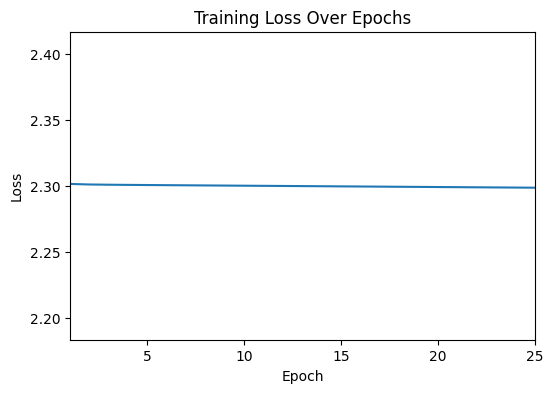

In [8]:
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

# Create a loss animation
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss Over Epochs")
line1, = ax1.plot([], [])  # no explicit colors

ax1.set_xlim(1, len(loss_history))
ax1.set_ylim(min(loss_history)*0.95, max(loss_history)*1.05)

def init_loss():
    line1.set_data([], [])
    return (line1,)

def update_loss(frame):
    xdata = np.arange(1, frame+2)
    ydata = loss_history[:frame+1]
    line1.set_data(xdata, ydata)
    return (line1,)

ani1 = animation.FuncAnimation(fig1, update_loss, frames=len(loss_history),
                               init_func=init_loss, interval=300, blit=True)
HTML(ani1.to_jshtml())



## 7. Animation — Probability Vector for One Example

We track the predicted probability distribution over the 10 digits for a **fixed** training image across epochs.


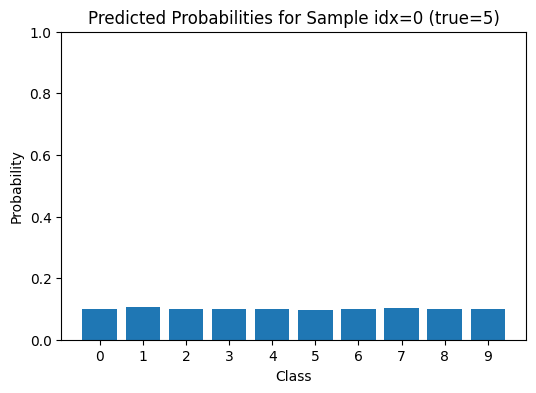

In [9]:

prob_array = np.stack(viz_prob_history, axis=0)  # (epochs, 10)
x_classes = np.arange(10)

fig2, ax2 = plt.subplots(figsize=(6,4))
ax2.set_xlabel("Class")
ax2.set_ylabel("Probability")
ax2.set_title(f"Predicted Probabilities for Sample idx={0} (true={viz_label})")
bar_container = ax2.bar(x_classes, prob_array[0])  # default colors

ax2.set_ylim(0.0, 1.0)
ax2.set_xticks(x_classes)

def update_bars(frame):
    probs = prob_array[frame]
    for rect, h in zip(bar_container, probs):
        rect.set_height(float(h))
    return bar_container.patches

ani2 = animation.FuncAnimation(fig2, update_bars, frames=prob_array.shape[0],
                               interval=300, blit=False)
HTML(ani2.to_jshtml())



## 8. Inference Helper (Try a few test digits)


In [10]:

def predict_proba(X):
    return softmax(X @ W + b)

def predict(X):
    return np.argmax(predict_proba(X), axis=1)

preds = predict(x_test[:10])
print("Predictions for first 10 test digits:", preds)
print("Ground truth:", y_test[:10])


Predictions for first 10 test digits: [1 1 1 1 1 1 1 1 1 1]
Ground truth: [7 2 1 0 4 1 4 9 5 9]



## 9. Summary

- **Architecture**: `784 → Linear (W,b) → Softmax → 10`.
- **Forward**: \(Z = XW + b\), \(\hat{Y}=\mathrm{softmax}(Z)\).
- **Loss**: mean cross‑entropy.
- **Backprop**: \(\\frac{\\partial L}{\\partial Z} = \\hat{Y}-Y\),  
  \(\\frac{\\partial L}{\\partial W} = \\frac{1}{m}X^\\top(\\hat{Y}-Y)\),  
  \(\\frac{\\partial L}{\\partial b} = \\frac{1}{m}\\sum_i(\\hat{Y}_i-Y_i)\\).
- **Training**: gradient descent on \(W,b\).
- **Animations**: loss over epochs; probability bars for one example.
